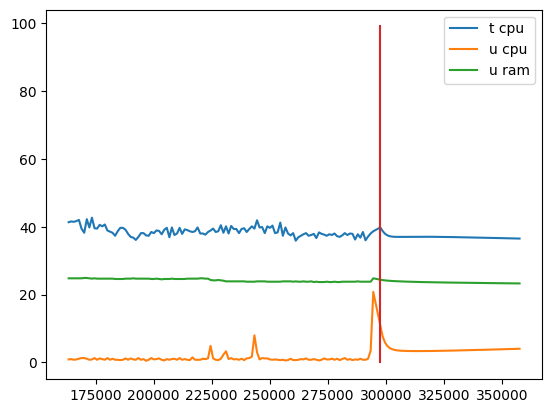

In [7]:
from arbeitAI import predict_temp_cpu_if_not_gpu, predict_usage_cpu_if_not_gpu, predict_ram_if_not_gpu

import sqlite3
import numpy as np
import sqlite3

from arbeitAI.utils import to_model
def arbeit_model():
    with sqlite3.connect('data.db') as conn:
        cur = conn.cursor()
        cur.execute("select * from compinfo")
        f = cur.fetchall()
        
        try:
            r = f[::-1][:120][::-1]
        except IndexError:
            r = f
        cur.close()
    
    sl = np.array(r)
    

    kritical_temperature_cpu = sl[1, 2]
    
    sl = np.delete(sl, 2, axis = 1)
    flag_give_gpu = bool(sl[1, 2] + 1)

    if not flag_give_gpu:
        sl = np.delete(sl, 2, axis=1)
        sl = np.delete(sl, 3, axis=1)
    
    # Таблица без GPU После изменений принимает вид:
    
    # Uptime - Temp_CPU - CPU_usage - RAM_usage 
    
    if not flag_give_gpu:
        all_predicter_if_not_gpu(sl)

def all_predicter_if_not_gpu(sl):
    sut = sl[-1, 0]
    
    future_temp_cpu = predict_temp_cpu_if_not_gpu(sl)
    
    future_usage_cpu = predict_usage_cpu_if_not_gpu(sl)
    
    future_usage_ram = predict_ram_if_not_gpu(sl)
    
    tutime = read_last()[0]
    loh = [tutime+1000, float(future_temp_cpu[0]), float(future_usage_cpu[0, 0]), float(future_usage_ram[0, 0])]
    tutime += 1000
    for _ in range(60):
        sl = np.vstack((sl, loh))
        future_temp_cpu = predict_temp_cpu_if_not_gpu(sl)
    
        future_usage_cpu = predict_usage_cpu_if_not_gpu(sl)
    
        future_usage_ram = predict_ram_if_not_gpu(sl)
        loh = [tutime+1000, float(future_temp_cpu[0]), float(future_usage_cpu[0, 0]), float(future_usage_ram[0, 0])]

        tutime+=1000
    
    from matplotlib.pyplot import subplots, show
    fig, axs = subplots(1, 1)
    axs.plot(sl[:, 0], sl[:, 1], label='t cpu')
    axs.plot(sl[:, 0], sl[:, 2], label='u cpu')
    axs.plot(sl[:, 0], sl[:, 3], label='u ram')
    axs.plot([sut] * 100, np.arange(100))
    axs.legend()
    show()
    
def read_all() -> list[tuple[int, float, float, float, float, float, float]]:
    with sqlite3.connect('data.db') as conn:
        cur = conn.cursor()
        cur.execute('SELECT * FROM compinfo')
        r = cur.fetchall()
        cur.close()
    return r

def read_last() -> tuple[int, float, float, float, float, float, float]:
    return read_all()[-1]

arbeit_model()